# !python3 -m venv venv
!cd venv
!source venv/bin/activate
!pip install scipy
!pip install tabulate

In [16]:
#CS458 Final Project
#Created by: Alvin Leung and Mark Marsala
#Decide how many ids to look at
# n = 20000 #5% of 400K videos
p = 5
p = p/100

In [2]:
from urllib.request import urlretrieve
import os
from zipfile import ZipFile
import shutil
import pandas as pd
import math
import networkx as nx
import csv
from matplotlib import pylab
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
from numpy import nan

file_name_on_web = "0222"
# file_name_on_web = "0302"
url = ("https://netsg.cs.sfu.ca/youtubedata/0222.zip")
# url = ("https://netsg.cs.sfu.ca/youtubedata/0302.zip")
filename = "data.zip"
dir_name = "data"
path, headers = urlretrieve(url, filename)
for name, value in headers.items():
    print(name, value)

Date Wed, 22 Nov 2023 00:01:21 GMT
Server Apache/2.4.6 (Red Hat Enterprise Linux) OpenSSL/1.0.2k-fips PHP/5.4.16
Last-Modified Fri, 21 Mar 2008 07:56:12 GMT
ETag "66b28dc-448edd1d9bf00"
Accept-Ranges bytes
Content-Length 107686108
Connection close
Content-Type application/zip


In [3]:
with ZipFile(filename, 'r') as zObject: 
    # Extracting all the members of the zip  
    # into a specific location. 
    zObject.extractall( 
        path=dir_name) 

In [4]:
data_path = os.path.join(dir_name, file_name_on_web)
files = os.listdir(data_path)
files.pop()


'log.txt'

In [5]:
def get_lines(file):
    text = open(os.path.join(data_path, file), 'r').read()
    lines = []
    for line in text.split('\n'):
        lines.append(line.split('\t'))
    return lines

def get_df(file):
    lines = get_lines(file)
    df = pd.DataFrame(lines, columns=None)
    return df

def giant_df(files):
    df = pd.DataFrame()
    for file in files:
        df = pd.concat([df, get_df(file)])
    df.columns = ["video_id", "uploader", "age", "category", "length", "views", "rate", "ratings", "comments","ri","ri","ri","ri","ri","ri","ri","ri","ri","ri","ri","ri","ri","ri","ri","ri","ri","ri","ri","ri"]
    # df.drop(df.tail(1).index,inplace=True)
    df['ris'] = [x for x in df[['ri']].to_numpy()]
    df.drop(labels=['ri'], axis=1, inplace = True)
    return df

def get_row(df, row):
    return df.iloc[[row], :]

def get_rows(df, start, end):
    temp_df = pd.DataFrame()
    for i in range(start, end):
        temp_df = pd.concat([temp_df, get_row(df, i)])
    return temp_df

#check if a column has any none values
def check_none(df, column):
    bad_indices = []
    for i in range(len(df)):
        try:
            val = df.loc[i,column]
            if isinstance(val, str) and val == "":
                bad_indices.append(i)
            if isinstance(val, float) and math.isnan(val):
                bad_indices.append(i)
        except:
            bad_indices.append(i)
    return bad_indices

def rid_bad_indices (df, bad_ind):
    for ind in bad_ind:
        df.drop(ind, inplace=True)

full_df = giant_df(files)
full_df.to_csv('data.csv')
df = pd.read_csv('data.csv').drop(labels=['Unnamed: 0'], axis=1)
bad_indices = check_none(df, 'video_id')
rid_bad_indices(df, bad_indices)
df.reset_index(drop=True, inplace=True)
df.drop(labels=['uploader'], axis=1, inplace = True)

In [6]:
related_ids = df['ris'].values
cleaned_ids = []

for id in related_ids:
    cleaned_ids.append(id.replace('[', '').replace(']', '').replace("'","").replace("\n","").split(' '))



In [7]:
def convert_string_to_list(string):
    return string.replace('[', '').replace(']', '').replace("'","").replace("\n","").split(' ')

def get_links(df, dictionary):
    links = []
    for index, row in df.iterrows():
        video_id = row['video_id']
        related_ids = convert_string_to_list(row['ris'])
        for id in related_ids:
            if(id == 'None'): continue
            elif (id not in dictionary): continue
            links.append((dictionary[video_id], dictionary[id]))
    return links

def create_dictionary(df):
    dictionary = {}
    integer = 0
    for index, row in df.iterrows():
        video_id = row['video_id']
        # related_ids = convert_string_to_list(row['ris'])
        dictionary[video_id] = integer
        integer += 1
    return dictionary

In [8]:
df['related_ids'] = cleaned_ids
df.drop(labels=['ris'], axis=1, inplace = True)
df.to_csv('data.csv')
data = pd.read_csv('data.csv') 
ids = data['video_id'].tolist()
rel_ids = data['related_ids'].tolist()

In [29]:
indexAge = df[ (df['category'] == " UNA ") | (df['category'] == nan) ].index
df.dropna(subset=['category'], inplace=True)
df.drop(indexAge, inplace=True)
df.category.unique()

array(['Entertainment', 'Music', 'Comedy', 'People & Blogs',
       'Travel & Places', 'Film & Animation', 'Sports', 'News & Politics',
       'Gadgets & Games', 'Howto & DIY', 'Pets & Animals',
       'Autos & Vehicles'], dtype=object)

In [30]:
df

,video_id,age,category,length,views,rate,ratings,comments,related_ids
0,LKh7zAJ4nwo,653.0,Entertainment,424.0,13021.0,4.34,1305.0,744.0,"[DjdA-5oKYFQ, NxTDlnOuybo, c-8VuICzXtU, DH56yr..."
1,7D0Mf4Kn4Xk,583.0,Music,201.0,6508.0,4.19,687.0,312.0,"[e2k0h6tPvGc, yuO6yjlvXe8, VqpnWBo-R4E, bdDskr..."
2,n1cEq1C8oqQ,525.0,Comedy,125.0,1687.0,4.01,363.0,141.0,"[eprHhmurMHg, i30NkTJOrak, 2XtLgZol5wI, 3nH5Tc..."
3,OHkEzL4Unck,638.0,Comedy,299.0,8043.0,4.40,518.0,371.0,"[eyUSTmEUQRg, FDIH1GNQXQE, Wtj31off8-I, mDjwzh..."
4,-boOvAGNKUc,639.0,Music,287.0,7548.0,4.48,606.0,386.0,"[fmUwUURgsX0, bR27ACWomug, LlH7WcVptw8, saBmFp..."
...,...,...,...,...,...,...,...,...,...
749356,IngMuIYqzHs,625.0,News & Politics,402.0,9523.0,3.67,21.0,52.0,"[UDZQNy_xLFk, dmXpbT7Fhiw, Ij1jwOodytM, vO8CcM..."
749357,UDZQNy_xLFk,625.0,News & Politics,428.0,5680.0,3.80,15.0,18.0,"[IngMuIYqzHs, dmXpbT7Fhiw, Ij1jwOodytM, vO8CcM..."
749358,dpCm6wTEM28,338.0,News & Politics,133.0,20834.0,4.60,123.0,39.0,"[e8MVhIiy8UQ, R210Qb7DP7Y, A9J4o44LBdI, kEfssh..."
749359,XryvsJOIAKA,703.0,Music,451.0,6933.0,5.00,23.0,10.0,"[ZD70Sp5rHCw, Eo_SuKEiPYs, gUij8FCg0z8, mIpost..."


In [31]:
def convert_string_to_list(string):
    l = string.replace('[',"").replace(']',"").replace("'","").replace(" ","").replace('None',"").replace("\n","").split(',')
    ret = []
    for item in l:
        if item != '':
            ret.append(item)
    return ret

def convert_related_ids_to_lists(rel_ids):
    rel_converted = []
    for ids in rel_ids:
        rel_converted.append(convert_string_to_list(ids))
    return rel_converted

In [32]:
rel_converted = convert_related_ids_to_lists(rel_ids)
res = {}
for key in ids:
    for value in rel_converted:
        res[key] = value
        rel_converted.remove(value)
        break

In [33]:
G = nx.Graph()
G.add_edges_from([k,x] for k,v in res.items() for x in v)
pr = nx.pagerank(G)

In [34]:
vid_ids = df['video_id'].tolist()
new_dict = {k: pr[k] for k in vid_ids if k in pr}

In [35]:
sorted_pr = sorted(new_dict.items(), key=lambda x:x[1], reverse=True)
n = int(p*len(vid_ids))
top_n = [i[0] for i in sorted_pr[0:n]]
sorted_pr_ascending = sorted(new_dict.items(), key=lambda x:x[1], reverse=False)
bot_n = [i[0] for i in sorted_pr_ascending[0:n]]

In [36]:
with open('pagerankscores.txt', 'w') as f:
    for line in sorted_pr:
        f.write(str(line) + '\n')

In [37]:
# def generate_df_from_ids(ids,df):
#     empty_df = pd.DataFrame()
#     for id in ids:
#         row = df.loc[df['video_id'] == id]
#         empty_df = pd.concat([empty_df, row])
#     return empty_df

def generate_df_from_ids(ids,df):
    mask = df['video_id'].isin(ids)
    return(df[mask])

top_df = generate_df_from_ids(top_n,df).reset_index()
csv_name = 'top_' + str(n) + '.csv'
top_df.to_csv(csv_name,index = False)
bot_df = generate_df_from_ids(bot_n,df).reset_index()
csv_name = 'bot_'+str(n)+'.csv'
bot_df.to_csv(csv_name,index=False)

In [38]:
top_df_edges = pd.DataFrame(columns=['video_id','num_edges'])
bot_df_edges = pd.DataFrame(columns=['video_id','num_edges'])

In [39]:
for id in top_n:
    top_df_edges.loc[len(top_df_edges.index)] = [id,len(G.edges(id))]
for id in bot_n:
    bot_df_edges.loc[len(bot_df_edges.index)] = [id,len(G.edges(id))]

In [40]:
csv_name = 'top_' + str(n) + '_edges.csv'
top_df_edges.to_csv(csv_name,index = False)
csv_name = 'top_' + str(n) + '_edges.csv'
bot_df_edges.to_csv(csv_name,index=False)

In [41]:
top_cat_list = top_df['category'].tolist()
bot_cat_list = bot_df['category'].tolist()
all_cat_list = df['category'].tolist()

top_edges_list = top_df_edges['num_edges'].tolist()
bot_edges_list = bot_df_edges['num_edges'].tolist()

top_cat_count = Counter(top_cat_list)
bot_cat_count = Counter(bot_cat_list)
all_cat_count = Counter(all_cat_list)

top_table = []
for category, count in sorted(top_cat_count.items(), key=lambda x: x[1], reverse=True):
    top_table.append([category, count])
    
bot_table = []
for category, count in sorted(bot_cat_count.items(), key=lambda x: x[1], reverse=True):
    bot_table.append([category, count])
    
headers = ["Category", "Count"]
top_table_title = "Top Category Counts"
bot_table_title = "Bot Category Counts"

write_data = f"\n{top_table_title}\n" + tabulate(top_table, headers=headers, tablefmt="pretty", colalign=("center", "center"), 
                                                 numalign="center", showindex=False) + "\n"+ f"\n{bot_table_title}\n" + tabulate(bot_table, 
                                                headers=headers, tablefmt="pretty", colalign=("center", "center"), numalign="center", showindex=False)
text_title = 'top_bot_cat_'+str(n)+'.txt'

with open(text_title, 'w') as f:
    f.write(write_data)


In [42]:
def pie_chart(data,name):
    labels = list(data.keys())
    counts = list(data.values())
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Video Categories Distribution')
    plt.tight_layout()
    plt.savefig(name)
    plt.show()
    return

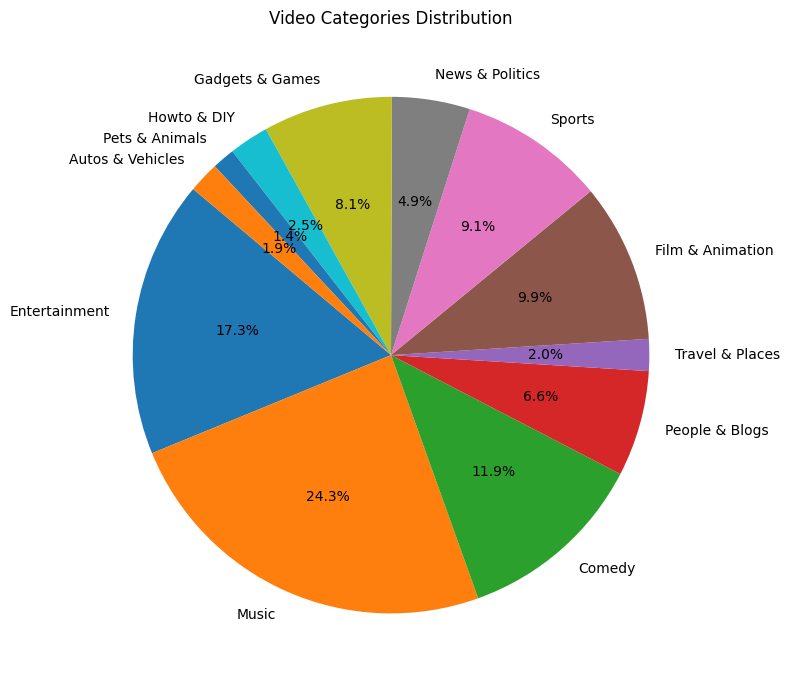

In [43]:
pie_chart(all_cat_count,"all_videos.png")

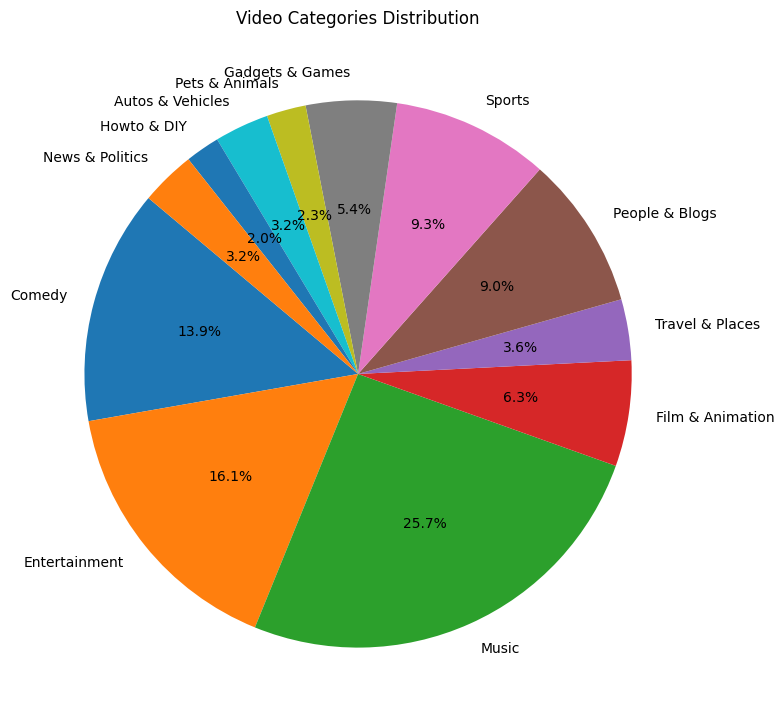

In [44]:
pie_chart(top_cat_count,"top_videos.png")

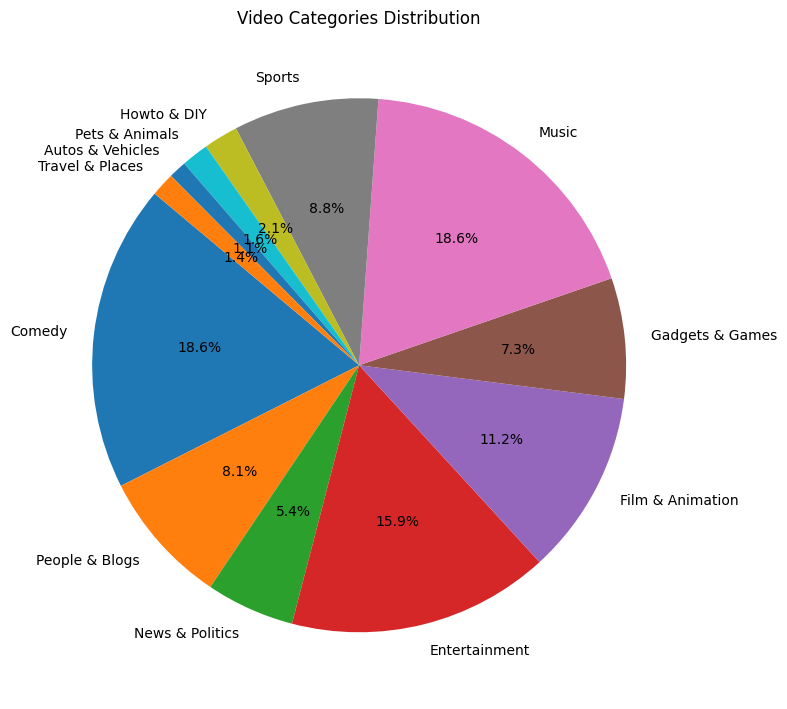

In [45]:
pie_chart(bot_cat_count,"bot_videos.png")

In [46]:
row_names = set(all_cat_list)

In [47]:
def generate_percentages(counter):
    total = sum(counter.values())
    ret = ""
    for face, count in counter.most_common():
        # data = data+(f"{face}: {count/total:.2%}") + "\n"
        percentage = str(f"{count/total:.2%}")
        ret = ret +str(face)+","+percentage+"\n"
    return ret

In [48]:
with open('all_cat_count.txt', 'w') as f:
    f.write(generate_percentages(all_cat_count))

In [49]:
with open("top_cat_count.txt", 'w') as f:
    f.write(generate_percentages(top_cat_count))

In [50]:
with open("bot_cat_count.txt", 'w') as f:
    f.write(generate_percentages(bot_cat_count))

In [51]:
print(generate_percentages(bot_cat_count))

Comedy,18.57%
Music,18.57%
Entertainment,15.86%
Film & Animation,11.17%
Sports,8.79%
People & Blogs,8.14%
Gadgets & Games,7.30%
News & Politics,5.36%
Howto & DIY,2.09%
Pets & Animals,1.65%
Travel & Places,1.44%
Autos & Vehicles,1.08%



In [52]:
def get_cat_perc(count_file):
    file = open(count_file, "r")
    categories = []
    percentages = []
    content = file.read().split("\n")
    for cont in content:
        if cont == "":
            continue
        broke = cont.split(",")
        cat = broke[0]
        if cat == " UNA ":
            cat = "UNA"
        if cat == "nan":
            cat = "NAN"
        perc = broke[1]
        categories.append(cat)
        percentages.append(perc)
    file.close()
    combined_lists = list(zip(categories,percentages))
    combined_lists.sort(key=lambda x: x[0])
    sorted_list1,sorted_list2 = zip(*combined_lists)
    return sorted_list1,sorted_list2

In [53]:
def generate_diff(perc2, perc1):
    rounded_difference_list = [round(float(perc1.strip('%')) - float(perc2.strip('%')), 2) for perc1, perc2 in zip(perc1, perc2)]
    return [f"{diff}%" for diff in rounded_difference_list]
categories = get_cat_perc("all_cat_count.txt")[0]
all_perc = get_cat_perc("all_cat_count.txt")[1]
top_perc = get_cat_perc("top_cat_count.txt")[1]
bot_perc = get_cat_perc("bot_cat_count.txt")[1]
headers = ['Categories', 'All Data', 'Top Data', 'Bottom Data', 'Top Diff', 'Bot Diff']
top_diff = generate_diff(all_perc,top_perc)
bot_diff = generate_diff(all_perc,bot_perc)
data = [categories,all_perc,top_perc,bot_perc,top_diff,bot_diff]
cat_df = pd.DataFrame(data, index = headers)
cat_df = cat_df.T
cat_df.to_csv('cat.csv')

In [54]:
# print(tabulate(list(zip(categories,all_perc,top_perc,bot_perc)), headers = headers, tablefmt='grid'))
cat_df

,Categories,All Data,Top Data,Bottom Data,Top Diff,Bot Diff
0,Autos & Vehicles,1.94%,3.21%,1.08%,1.27%,-0.86%
1,Comedy,11.91%,13.87%,18.57%,1.96%,6.66%
2,Entertainment,17.31%,16.09%,15.86%,-1.22%,-1.45%
3,Film & Animation,9.94%,6.25%,11.17%,-3.69%,1.23%
4,Gadgets & Games,8.11%,5.36%,7.30%,-2.75%,-0.81%
5,Howto & DIY,2.48%,2.03%,2.09%,-0.45%,-0.39%
6,Music,24.28%,25.70%,18.57%,1.42%,-5.71%
7,News & Politics,4.87%,3.24%,5.36%,-1.63%,0.49%
8,People & Blogs,6.63%,9.04%,8.14%,2.41%,1.51%
9,Pets & Animals,1.42%,2.32%,1.65%,0.9%,0.23%


In [57]:
combined_lists = list(zip(categories,top_diff))
combined_lists.sort(key=lambda x: x[1], reverse = True)
sorted_list1,sorted_list2 = zip(*combined_lists)

data = [sorted_list1, sorted_list2]
t_diff_df = pd.DataFrame(data, index = ['top_categories','top_diff']).T

combined_lists = list(zip(categories,bot_diff))
combined_lists.sort(key=lambda x: x[1], reverse = True)
sorted_list1,sorted_list2 = zip(*combined_lists)

data = [sorted_list1, sorted_list2]
b_diff_df = pd.DataFrame(data, index = ['bot_categories','bot_diff']).T

In [58]:
differences_df = pd.concat([t_diff_df,b_diff_df], axis=1)
differences_df.to_csv("diff.csv")

In [59]:
differences_df

,top_categories,top_diff,bot_categories,bot_diff
0,People & Blogs,2.41%,Comedy,6.66%
1,Comedy,1.96%,People & Blogs,1.51%
2,Travel & Places,1.61%,Film & Animation,1.23%
3,Music,1.42%,News & Politics,0.49%
4,Autos & Vehicles,1.27%,Pets & Animals,0.23%
5,Pets & Animals,0.9%,Music,-5.71%
6,Sports,0.14%,Entertainment,-1.45%
7,Film & Animation,-3.69%,Autos & Vehicles,-0.86%
8,Gadgets & Games,-2.75%,Gadgets & Games,-0.81%
9,News & Politics,-1.63%,Travel & Places,-0.55%


In [16]:
# from matplotlib import pylab
# import matplotlib.pyplot as plt

# def save_graph(graph,file_name):
#     #initialze Figure
#     plt.figure(num=None, figsize=(20, 20), dpi=80)
#     plt.axis('off')
#     fig = plt.figure(1)
#     pos = nx.spring_layout(graph)
#     nx.draw_networkx_nodes(graph,pos)
#     nx.draw_networkx_edges(graph,pos)
#     nx.draw_networkx_labels(graph,pos)

#     cut = 1.00
#     xmax = cut * max(xx for xx, yy in pos.values())
#     ymax = cut * max(yy for xx, yy in pos.values())
#     plt.xlim(0, xmax)
#     plt.ylim(0, ymax)

#     plt.savefig(file_name,bbox_inches="tight")
#     pylab.close()
#     del fig

# #Assuming that the graph g has nodes and edges entered
# save_graph(G,"my_graph.pdf")

In [17]:
# #Delete files
# try:
#     os.remove("data.csv")
# except:
#     print("data.csv does not exist")
# try:
#     os.remove(filename)
# except:
#     print(filename, "does not exist")
# try:
#     shutil.rmtree(data_path, ignore_errors=False, onerror=None)
# except:
#     print(data_path, "does not exist")
# try:
#     os.rmdir(dir_name)
# except:
#     print(dir_name, "does not exist")